<h1>Computing Sea Surface Elevation Estimates</h1>
Written By: EJ Rainville, Spring 2022
Goal: We want to compute a time series of the sea surface elevation from the data from the microSWIFTs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import signal
from scipy import interpolate
from scipy import optimize
import cftime
import netCDF4 as nc
%matplotlib widget

In [2]:
class microSWIFT:
    def __init__(self, mission_dataset, microSWIFT_num):
        ''' '''
        # Get all variables from microSWIFT
        microSWIFT_nc_group = mission_dataset[microSWIFT_num]
        self.time = mission_dataset['time'][:]
        self.time_datetime = cftime.num2pydate(mission_dataset['time'][:], units=mission_dataset['time'].units, calendar=mission_dataset['time'].calendar)
        self.sampling_freq = mission_dataset['imu_freq'][:]

        # Define all measurements as variables of the microSWIFT class
        self.ax_body = microSWIFT_nc_group['accel_x'][:]
        self.ay_body = microSWIFT_nc_group['accel_y'][:]
        self.az_body = microSWIFT_nc_group['accel_z'][:] 
        self.gyro_x = microSWIFT_nc_group['gyro_x'][:]
        self.gyro_y = microSWIFT_nc_group['gyro_y'][:]
        self.gyro_z = microSWIFT_nc_group['gyro_z'][:]
        self.mag_x = microSWIFT_nc_group['mag_x'][:]
        self.mag_y = microSWIFT_nc_group['mag_y'][:]
        self.mag_z = microSWIFT_nc_group['mag_z'][:]
        self.x = microSWIFT_nc_group['xFRF'][:]
        self.y = microSWIFT_nc_group['yFRF'][:]
        self.z = microSWIFT_nc_group['gpsElevation'][:]
        self.u = microSWIFT_nc_group['u'][:]
        self.v = microSWIFT_nc_group['v'][:]

        # Linearly interolate to fill any nan values with an interpolated value
        accel_nans = np.isnan(self.ax_body)
        self.ax_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.ax_body[~accel_nans])
        self.ay_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.ay_body[~accel_nans])
        self.az_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.az_body[~accel_nans])
        self.gyro_x[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_x[~accel_nans])
        self.gyro_y[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_y[~accel_nans])
        self.gyro_z[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_z[~accel_nans])
        self.mag_x[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_x[~accel_nans])
        self.mag_y[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_y[~accel_nans])
        self.mag_z[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_z[~accel_nans])

def transform2FRF(lat,lon):
    '''
    @edwinrainville, Originally written by J. Thomson, 1/2011

    Description: function to convert from lat & lon (decimal degrees, negative longitude) to FRF x,y (meters)
    '''

    # Define offsets
    lat_offset = 36.178039
    lon_offset = -75.749672

    # Define constants
    rotation = 19 #rotation in degress CCW from True north

    # Radius of Earth
    earth_rad = 6378.1 * 1000 # units are meters

    # correct radius for latitutde 
    radius_at_latoffset = earth_rad * np.cos(np.deg2rad(np.median(lat_offset))) 

    # Compute North-South and East-West Locations
    north = earth_rad * np.deg2rad(lat- lat_offset)
    east = radius_at_latoffset * np.deg2rad(lon_offset - lon) 

    # Rotate Coordinates by 19 degrees CCW from True north
    x = east * np.cos(np.deg2rad(rotation))   -   north * np.sin (np.deg2rad(rotation))
    x = -x # Flip x 
    y = east * np.sin(np.deg2rad(rotation))   +   north * np.cos (np.deg2rad(rotation))

    # return x and y values
    return x, y

Let's start first by choosing a test data set. This dataset will be Mission 30 from the main DUNEX experiment. This dataset was chosen since it was near the 4.5 m AWAC for a very long time and we will use that to compare the spectra from the AWAC and the microSWIFT to see how well the microSWIFT is statistically able to produce the same spectra.



In [3]:
# Load Mission 30 dataset and look at microSWIFT 12
mission_dataset = nc.Dataset('../microSWIFT_data/cleanedDataset/mission_30.nc')
microSWIFT_test = microSWIFT(mission_dataset, microSWIFT_num='microSWIFT_12')
print('Start of this Mission: {}'.format(microSWIFT_test.time_datetime[0]))


Start of this Mission: 2021-10-13 14:18:00


In [4]:
# Data from 4.5 meter AWAC
awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
time_index = 302
f_awac = awac_data['waveFrequency'][:]
E_awac = awac_data['waveEnergyDensity'][time_index,:]
xFRF_awac, yFRF_awac = transform2FRF(np.float64(awac_data['latitude'][:]), np.float64(awac_data['longitude'][:]))
print('Time of Spectra: {}'.format(cftime.num2pydate(awac_data['time'][:], units=awac_data['time'].units, calendar=awac_data['time'].calendar)[time_index]))
print('4.5 m AWAC: Hs = {0:.2f} meters'.format(awac_data['waveHs'][time_index]))
print('4.5 m AWAC: Tp = {0:.2f} seconds'.format(awac_data['waveTp'][time_index]))

Time of Spectra: 2021-10-13 14:00:06
4.5 m AWAC: Hs = 1.27 meters
4.5 m AWAC: Tp = 5.91 seconds


Now that we have the microSWIFT data and the AWAC data that we are interested in examining, lets see how close the microSWIFT actually was to the AWAC during this deployment.

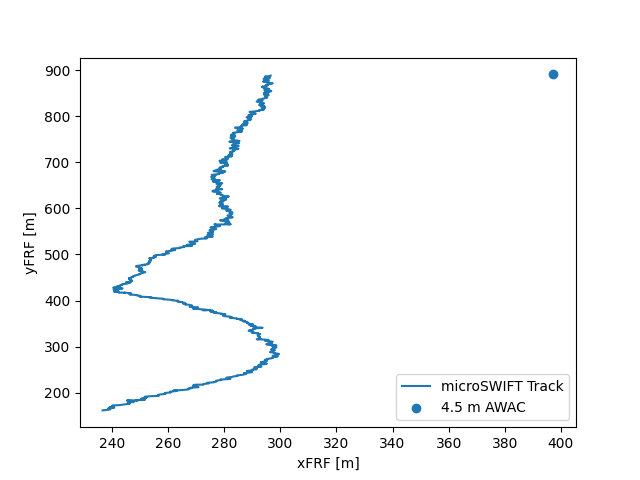

In [5]:
# Plot track of the microSWIFT and the location of the AWAC
fig_location, ax = plt.subplots()
ax.plot(microSWIFT_test.x, microSWIFT_test.y, label='microSWIFT Track')
ax.scatter(xFRF_awac, yFRF_awac, label='4.5 m AWAC')
ax.set_xlabel('xFRF [m]')
ax.set_ylabel('yFRF [m]')
ax.legend()

Now looking at the track and the location of the AWAC, we will assume that the time when the microSWIFT is between 900 and 700 meters in the yFRF location that it should have a very similar spectra(shoaled from the AWAC) to the AWAC. So the next step is to subset the data to include only that chunk of data for this analysis.

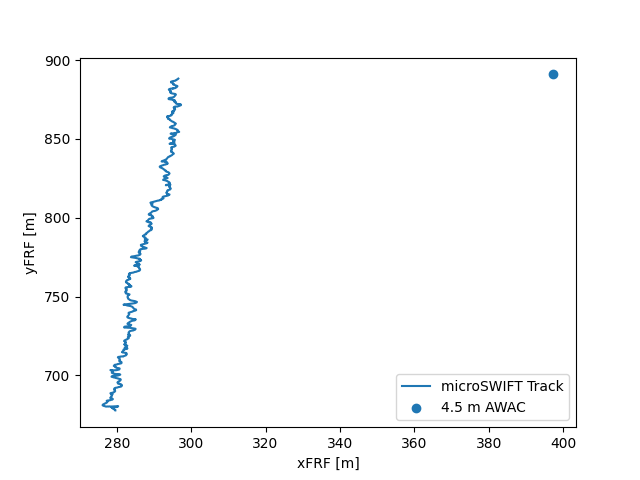

In [6]:
# Subset of data when microSWIFT is between 900 and 700 meters in yFRF coordinates
start_ind = 0
end_ind = 6000
fig_location, ax = plt.subplots()
ax.plot(microSWIFT_test.x[start_ind:end_ind], microSWIFT_test.y[start_ind:end_ind], label='microSWIFT Track')
ax.scatter(xFRF_awac, yFRF_awac, label='4.5 m AWAC')
ax.set_xlabel('xFRF [m]')
ax.set_ylabel('yFRF [m]')
ax.legend()

Now going from index 0 to index 6000 we have a subset of data where the microSWIFT is just in front of the 4.5 meter AWAC. This subset of data has 6000 data points which is aprroximately 500 seconds of data or 8.3 minutes of data. The next step is to look at the energy spectrum from the 4.5 meter AWAC and get a feel for the data that we expect.

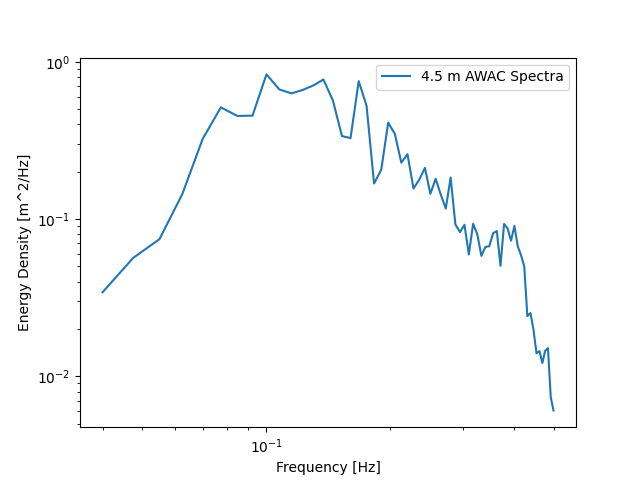

In [7]:
# Plot 4.5 Meter AWAC Spectra 
fig_awac_spec, ax = plt.subplots()
ax.loglog(f_awac, E_awac, label='4.5 m AWAC Spectra')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Energy Density [m^2/Hz]')
ax.legend()

Now we want to anaylze the acceleration data during the period of interest from the microSWIFT.

<class 'numpy.ndarray'>


Text(0, 0.5, 'Acceleration [m/s^2]')

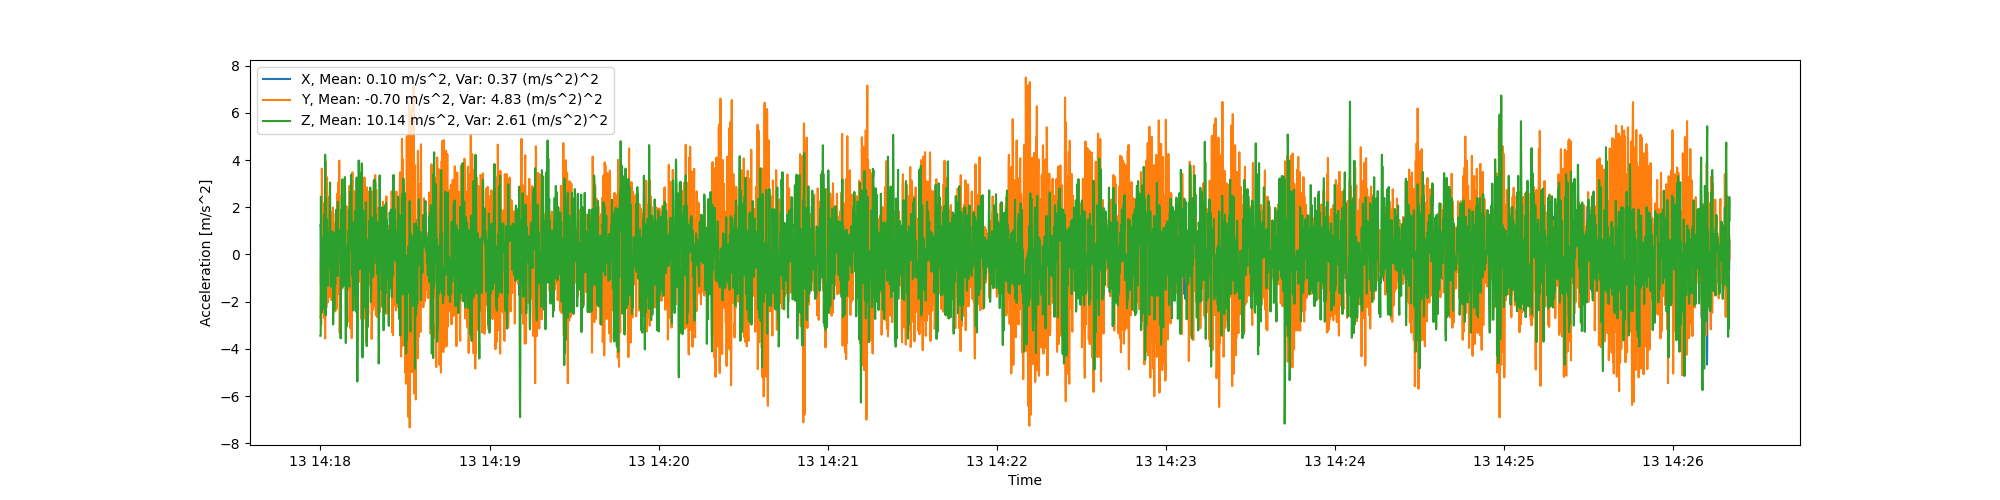

In [8]:
# Define time during the period of interest
time_datetime = microSWIFT_test.time_datetime[start_ind:end_ind]
time = microSWIFT_test.time[start_ind:end_ind]

# Define acceleration variables during the mission
accel_x = np.array(microSWIFT_test.ax_body[start_ind:end_ind])
accel_y = np.array(microSWIFT_test.ay_body[start_ind:end_ind])
accel_z = np.array(microSWIFT_test.az_body[start_ind:end_ind])
print(type(accel_x))
# Compute the Mean value of acceleration 
accel_x_mean = np.mean(accel_x)
accel_y_mean = np.mean(accel_y)
accel_z_mean = np.mean(accel_z)

# Compute Variance of Acceleration
accel_x_var = np.var(accel_x)
accel_y_var = np.var(accel_y)
accel_z_var = np.var(accel_z)

# Remove the Mean from each acceleration
accel_x_demean = accel_x - accel_x_mean
accel_y_demean = accel_y - accel_y_mean
accel_z_demean = accel_z - accel_z_mean

# Plot the Demeaned Accelerations
fig_accel_raw, ax = plt.subplots(figsize=(20,5))
ax.plot(time_datetime, accel_x_demean, label='X, Mean: {0:.2f} m/s^2, Var: {1:.2f} (m/s^2)^2'.format(accel_x_mean, accel_x_var))
ax.plot(time_datetime, accel_y_demean, label='Y, Mean: {0:.2f} m/s^2, Var: {1:.2f} (m/s^2)^2'.format(accel_y_mean, accel_y_var))
ax.plot(time_datetime, accel_z_demean, label='Z, Mean: {0:.2f} m/s^2, Var: {1:.2f} (m/s^2)^2'.format(accel_z_mean, accel_z_var))
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration [m/s^2]')


Currently, each signal looks really jumpy so it is hard to tell if there are any really coherent, wave-like structures. Funny enough, it almost looks like the Y acceleration shows more coherent wave structures than Z does which is strange. Lets look at these signals in the Fourier Domain and see whats up.

Text(0, 0.5, 'Amplitude [m/s^2]')

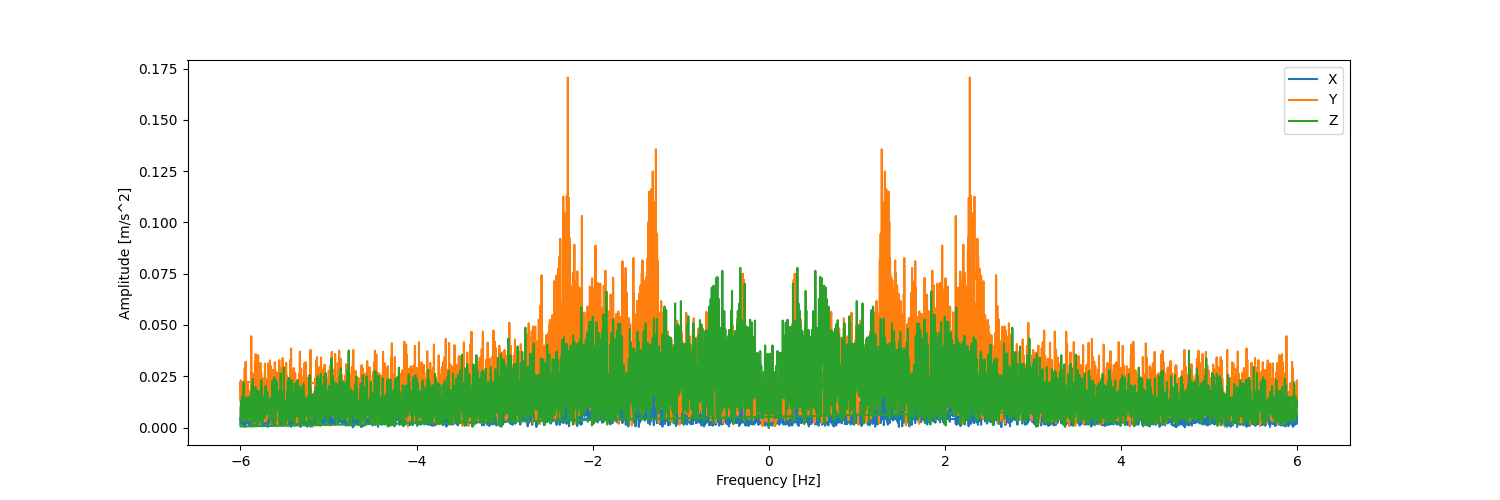

In [9]:
# Compute FFT of each demeaned acceleration signal
sample_freq = np.float64(microSWIFT_test.sampling_freq)
freq = np.fft.fftfreq(accel_x_demean.size, d=1/sample_freq)
#*Note this has been normalized by the number of points 
num_points = freq.size
accel_x_fft = np.fft.fft(accel_x_demean)/num_points
accel_y_fft = np.fft.fft(accel_y_demean)/num_points
accel_z_fft = np.fft.fft(accel_z_demean)/num_points

# Plot the Real Part of the FFT for each acceleration
fig_accel_fft, ax = plt.subplots(figsize=(15,5))
ax.plot(freq, np.abs(accel_x_fft), label='X')
ax.plot(freq, np.abs(accel_y_fft), label='Y')
ax.plot(freq, np.abs(accel_z_fft), label='Z')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [m/s^2]')


Now lets make this a one sided spectrum to analyze closer and integrate it in the Fourier domain.

Text(0, 0.5, 'Amplitude [m/s^2]')

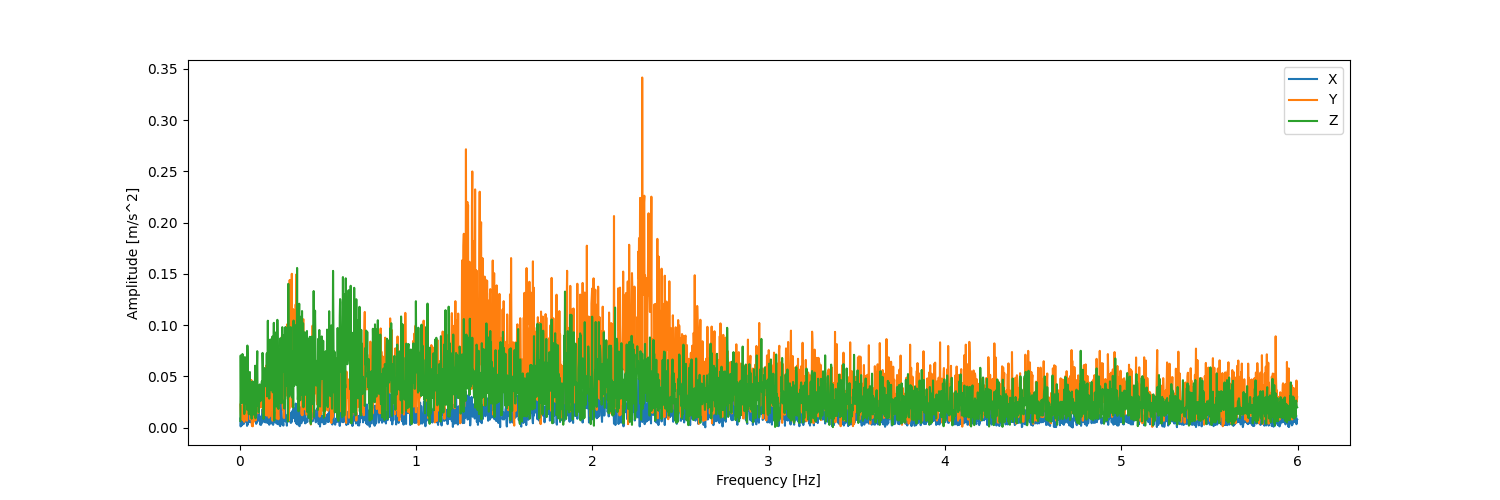

In [10]:
# Find all indices of the frequnecy greater than 0
onesided_ind = freq > 0
freq_onesided = freq[onesided_ind]

# Note that the one sided spectrum must be rescaled by a factor of 2 
accel_x_fft_onesided = accel_x_fft[onesided_ind] * 2
accel_y_fft_onesided = accel_y_fft[onesided_ind] * 2
accel_z_fft_onesided = accel_z_fft[onesided_ind] * 2

# Plot the one sided spectrum to examine it in more detail 
fig_accel_fft_onesided, ax = plt.subplots(figsize=(15,5))
ax.plot(freq_onesided, np.abs(accel_x_fft_onesided), label='X')
ax.plot(freq_onesided, np.abs(accel_y_fft_onesided), label='Y')
ax.plot(freq_onesided, np.abs(accel_z_fft_onesided), label='Z')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [m/s^2]')



When we look at this one sided spectrum, we see that the z acceleration is almost not affected at frequencies higher than the wave band while the y acceleration is drastically affected at higher frequencies. This leads me to the thought that potentialyl correcting this could make it worse and maybe just filtering the z acceleration is the way after all. Lets try now to just integrate this signal and see what happens.

Text(0, 0.5, 'Amplitude [m]')

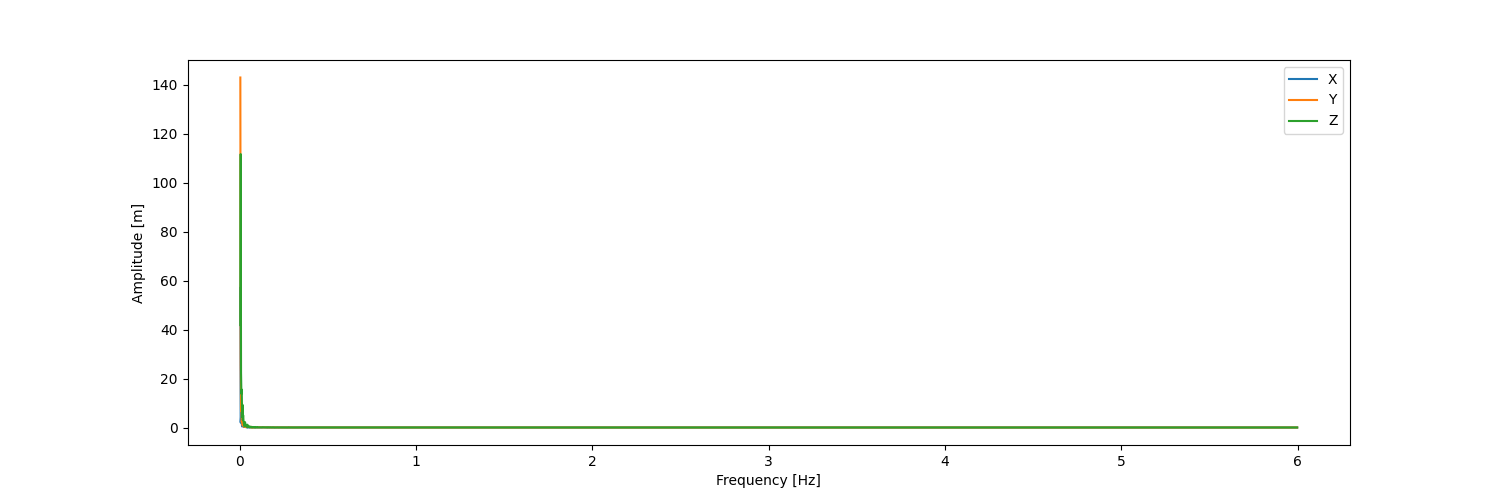

In [11]:
# Define integration array from the frequencies
double_integration_array = -1 / ((2 * np.pi * freq_onesided)**2)

# Now multiply each of the acceleration fft's by this array to get the integrated fourier transform 
x_fft_onesided = double_integration_array * accel_x_fft_onesided
y_fft_onesided = double_integration_array * accel_y_fft_onesided
z_fft_onesided = double_integration_array * accel_z_fft_onesided

# Plot the integrated spectra of position
fig_pos_fft_onesided, ax = plt.subplots(figsize=(15,5))
ax.plot(freq_onesided, np.abs(x_fft_onesided), label='X')
ax.plot(freq_onesided, np.abs(y_fft_onesided), label='Y')
ax.plot(freq_onesided, np.abs(z_fft_onesided), label='Z')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [m]')

Wow this is impressive! The low frequency components sky rocket while the rest of the components are almost zero. This most definetly needs to be fixed with some sort of filter. Lets first try by zeroing out all components of acceleration below 0.045 (just below the wave band) which is where it seems to have the largest explosion due to multiplying by orders or magnitude!

Text(0, 0.5, 'Amplitude [m]')

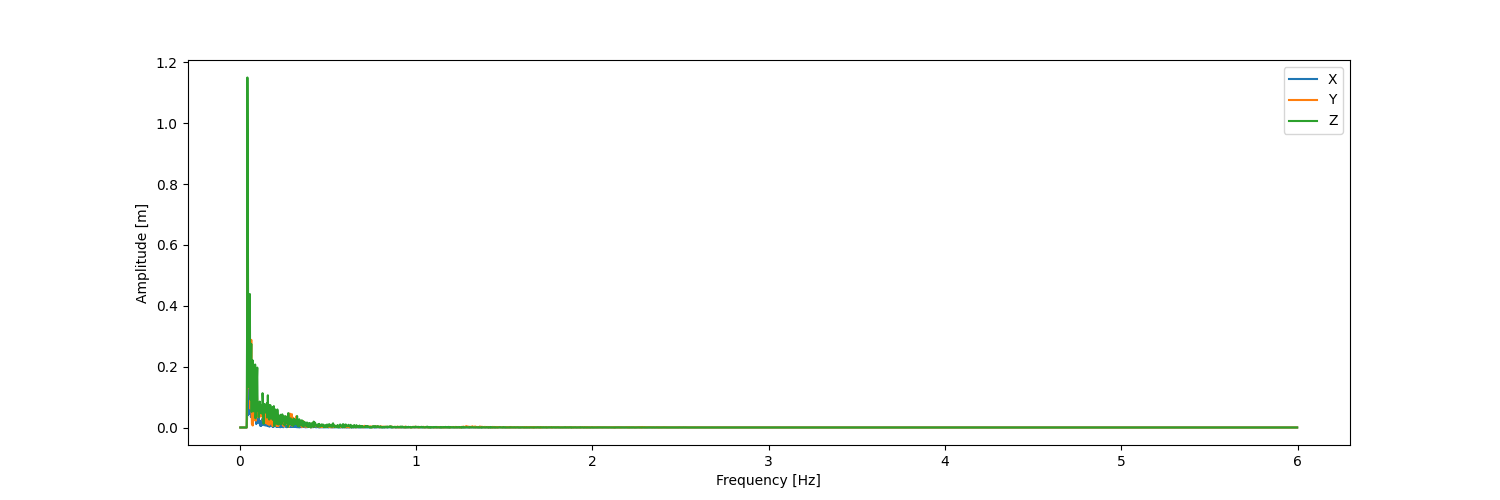

In [12]:
# Find all indices of frequnecy between zero and 0.01
low_freq_ind = freq_onesided < 0.04

# Zero out all low frequency components of acceleration and integrate again 
accel_x_fft_onesided_low_freq_cut = accel_x_fft_onesided.copy()
accel_x_fft_onesided_low_freq_cut[low_freq_ind] = 0
accel_y_fft_onesided_low_freq_cut = accel_y_fft_onesided.copy()
accel_y_fft_onesided_low_freq_cut[low_freq_ind] = 0
accel_z_fft_onesided_low_freq_cut = accel_z_fft_onesided.copy()
accel_z_fft_onesided_low_freq_cut[low_freq_ind] = 0

# Double integrate the Acceleratiosn again and plot to see what happens
x_fft_onesided_low_freq_cut = double_integration_array * accel_x_fft_onesided_low_freq_cut
y_fft_onesided_low_freq_cut = double_integration_array * accel_y_fft_onesided_low_freq_cut
z_fft_onesided_low_freq_cut = double_integration_array * accel_z_fft_onesided_low_freq_cut

# Plot the integrated spectra of position
fig_pos_fft_onesided, ax = plt.subplots(figsize=(15,5))
ax.plot(freq_onesided, np.abs(x_fft_onesided_low_freq_cut), label='X')
ax.plot(freq_onesided, np.abs(y_fft_onesided_low_freq_cut), label='Y')
ax.plot(freq_onesided, np.abs(z_fft_onesided_low_freq_cut), label='Z')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [m]')

Well this looks very good! Frusteratingly, it seems that the peak will most likely end up wherever the filter cut off is due to the nature of integrating those low frequency values. Hmm, what do we do about that? Well anyway for now, lets try computing the energy spectrum now and see how it compares with the spectrum from the 4.5 m AWAC. 

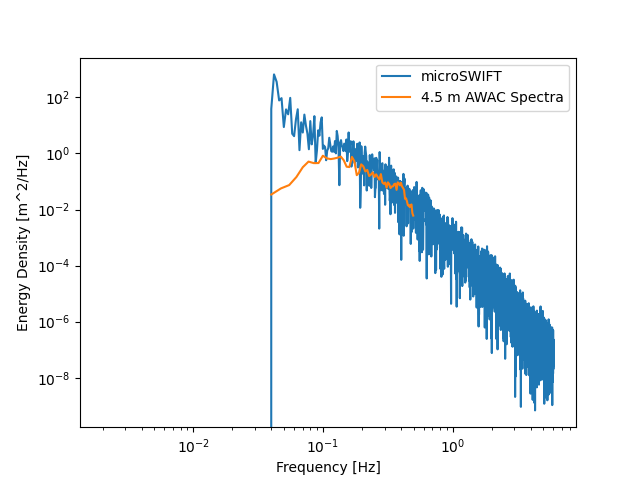

In [13]:
# Compute the Energy Density Spectrum of the position FFT of z which should be spectrum of sea surface elevation
# * Note that it is normalized by the frequency resolution to make a density
del_f = sample_freq / num_points
E_micro = np.abs(z_fft_onesided_low_freq_cut**2) / del_f

# Plot the Energy Spectrum compared to the AWAC spectrum
fig_spec, ax = plt.subplots()
ax.loglog(freq_onesided, E_micro, label='microSWIFT')
ax.loglog(f_awac, E_awac, label='4.5 m AWAC Spectra')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Energy Density [m^2/Hz]')
ax.legend()


This is very encouraging! We are getting a high frequency tail that is very representative of the energy spectrum from the AWAC with almost no filtering which is really nice! Now what do we do about the low frequency end? We need to develop a filter that will handle this low frequency end and reduce the energy in it. Lets try to solve for an optimized filter design by minimized the mean square error between the AWAC spectrum and the microSWIFT spectrum. Lets first see what the current mean square error is between the two.

In [14]:
# Interpolate the AWAC spectra onto the resolution of the microSWIFT spectra to compare one-to-one
E_awac_micro_res = np.interp(freq_onesided, f_awac, E_awac)

# Compute the Mean square error between the two spectra
mse = (1/E_micro.size) * np.sum((E_micro - E_awac_micro_res)**2)
print('Mean Square Error of microSWIFT Spectra compared to 4.5 m AWAC Spectra: {0:.2f} m^2/Hz'.format(mse))

Mean Square Error of microSWIFT Spectra compared to 4.5 m AWAC Spectra: 199.61 m^2/Hz


Ok so our mean square error is about 10, lets see if we can reduce this error by coming up with an optimal filter to reduce it.

Text(0, 0.5, 'Amplitude [m]')

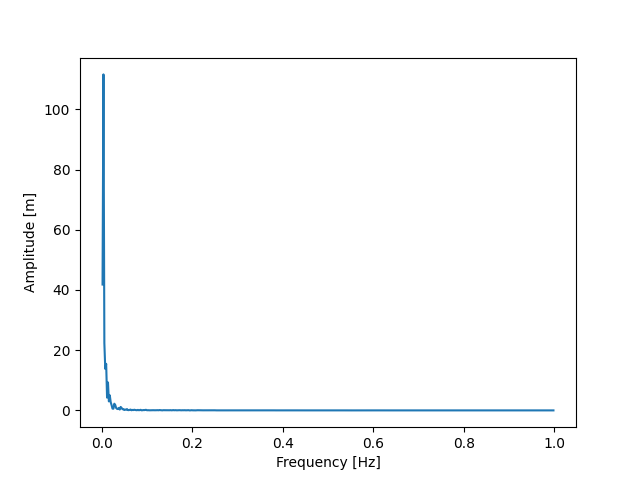

In [15]:
# Examine a smaller section to reduce computation 
ind_in_wave_band = freq_onesided < 1
freq_in_wave_band = freq_onesided[ind_in_wave_band]
z_fft_in_wave_band = z_fft_onesided[ind_in_wave_band]
#*Note since we want to find the optimal filter with this I dont want to use the spectra with componets already zeroed

# Plot the FFT in the wave band 
fig_waveband, ax = plt.subplots()
ax.plot(freq_in_wave_band, np.abs(z_fft_in_wave_band))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [m]')


In [16]:
def computeEnergySpectra(position_fft, filter_array, sample_freq):
    # Filter the position fft by multiplying by the filter array
    position_filt = position_fft * filter_array

    # Compute Energy Spectra from filtered position fft - onesided
    num_points = position_fft.size * 2 # multiplied by two since this is a one sided spectrum and the input was double this number of points
    del_f = sample_freq / num_points
    E = np.abs(position_filt**2) / del_f

    return E

def optimalFilterDesign(filter_array, position_fft, sample_freq, E_awac):
    # Compute the Energy Density from the position fft and filter
    E_micro = computeEnergySpectra(position_fft, filter_array, sample_freq)

    # Compute the Mean Square Error
    mse = (1/E_micro.size) * np.sum((E_micro - E_awac)**2)

    return mse
    
# Reinterpolate the AWAC spectra to be within the wave band 
E_awac_in_wave_band = np.interp(freq_in_wave_band, f_awac, E_awac)

# Define a basic filter of all ones to see what the optimal filter it gives out looks like
filter_guess = np.ones(freq_in_wave_band.size)

# Define the bounds of the optimization 
#*Note must be between zero and 1 since we are defining a filter and dont want to add extra energy to the measurements
# bnds = [(0, 1) for _ in filter_guess]

# Optimize the filter array by minimizing the mean square error 
res = optimize.minimize(optimalFilterDesign, x0=filter_guess, args=(z_fft_in_wave_band, sample_freq, E_awac_in_wave_band), tol=10, options={'maxiter':200, 'disp': True})
print(res)

Optimization terminated successfully.
         Current function value: 0.025053
         Iterations: 196
         Function evaluations: 109500
         Gradient evaluations: 219
      fun: 0.025052964032794504
 hess_inv: array([[ 2.25989364e-04, -2.62997124e-05, -1.69768239e-05, ...,
        -1.08465786e-06, -6.69734317e-07, -3.42343365e-06],
       [-2.62997124e-05,  7.82805501e-06,  6.93524138e-06, ...,
         2.91555589e-07,  1.82842490e-07,  9.55919425e-07],
       [-1.69768239e-05,  6.93524138e-06,  2.06470487e-04, ...,
         3.69289732e-07,  2.31857207e-07,  1.08217461e-06],
       ...,
       [-1.08465786e-06,  2.91555589e-07,  3.69289732e-07, ...,
         1.00000001e+00,  7.03819456e-09,  3.65623564e-08],
       [-6.69734317e-07,  1.82842490e-07,  2.31857207e-07, ...,
         7.03819456e-09,  1.00000000e+00,  2.28476048e-08],
       [-3.42343365e-06,  9.55919425e-07,  1.08217461e-06, ...,
         3.65623564e-08,  2.28476048e-08,  1.00000012e+00]])
      jac: array([-1.2

Text(0, 0.5, 'Amplitude')

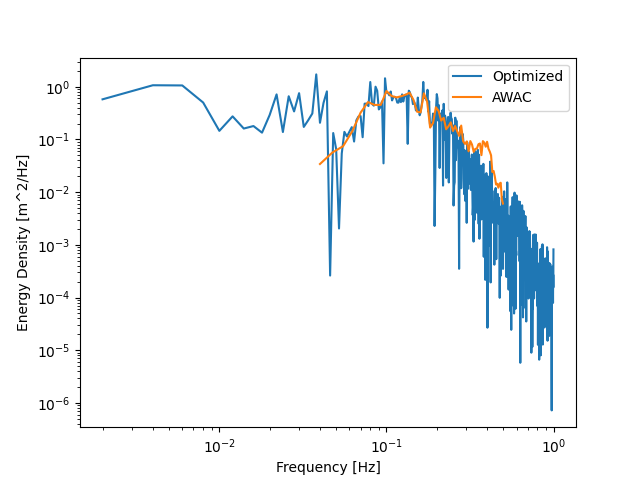

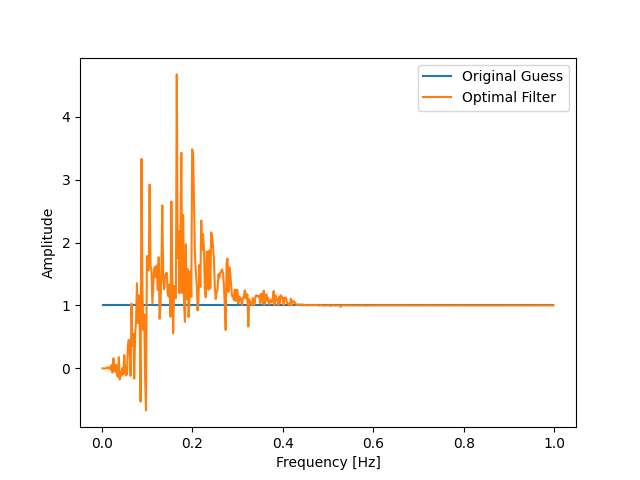

In [17]:
# Lets examine the Optimal Filter that it came up with
optimal_filter = res.x

# Compute the Spectra
E_optimized = computeEnergySpectra(z_fft_in_wave_band, optimal_filter, sample_freq)

# Plot the Optimized Spectra and the AWAC spectra
fig_optimal_spec, ax = plt.subplots()
ax.loglog(freq_in_wave_band, E_optimized, label='Optimized')
ax.loglog(f_awac, E_awac, label='AWAC')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Energy Density [m^2/Hz]')

# Plot the filter 
fig_filter, ax = plt.subplots()
ax.plot(freq_in_wave_band, filter_guess, label='Original Guess')
ax.plot(freq_in_wave_band, optimal_filter, label='Optimal Filter')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')

Well I haven't been able to figure out how to use the bounds function to optimize between 0 and 1 for the filter but here we see the major features are the values less than 0.05 are effectively zero (<0.2) and then there is some weirdness from there up to 0.1 where the filter then passes back over the line for one. There is then some super elvation after that which is adding values to the sigal artifically and we should not use. Lets try making a gaussian function that has a similar curve to the one that shows up and see how well it can do. 

Text(0, 0.5, 'Amplitude')

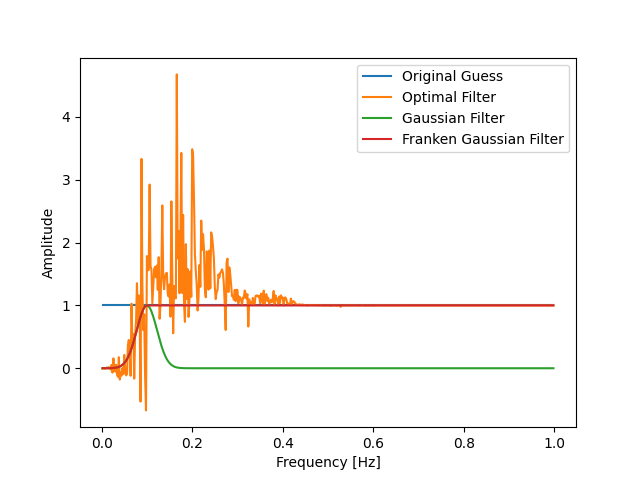

In [18]:
# Define a Gaussian filter
width = 0.0005
center = 0.1
gaussian_filter = (1/(np.sqrt(width * 2 * np.pi))) * np.exp(-0.5 * (freq_in_wave_band - center)**2 / width)
gaussian_filter_norm = gaussian_filter / np.max(gaussian_filter)

# Franken Gaussian where all values greater than center are one
franken_gaussian = gaussian_filter_norm.copy()
franken_gaussian[freq_in_wave_band > center] = 1

# Plot the filter compared to the optimal filter
fig_filter_test, ax = plt.subplots()
ax.plot(freq_in_wave_band, filter_guess, label='Original Guess')
ax.plot(freq_in_wave_band, optimal_filter, label='Optimal Filter')
ax.plot(freq_in_wave_band, gaussian_filter_norm, label='Gaussian Filter')
ax.plot(freq_in_wave_band, franken_gaussian, label='Franken Gaussian Filter')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')

Well now we have made some filters and they are related to the optimzed filter - lets see how they do in comparison. Also I wonder if there is anyway to recorrelate the location and width of this filter with the actual dataset, Hmmm.

Text(0, 0.5, 'Energy Density [m^2/Hz]')

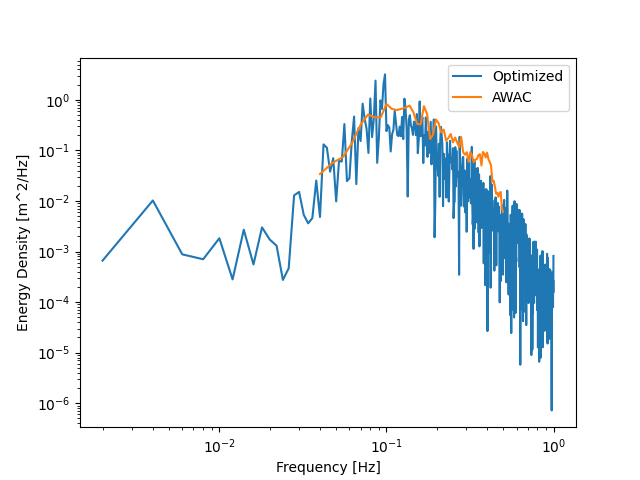

In [19]:
# Compute Spectrum with the Franken Gaussian
E_franken = computeEnergySpectra(z_fft_in_wave_band, franken_gaussian, sample_freq)

# Plot the Franken Spectra and the AWAC spectra
fig_optimal_spec, ax = plt.subplots()
ax.loglog(freq_in_wave_band, E_franken, label='Optimized')
ax.loglog(f_awac, E_awac, label='AWAC')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Energy Density [m^2/Hz]')

Well this looks very nice, the franken gaussian looks pretty good. Now we want to apply this filter to the position fft and then inverse FFT to see the time series. To start this we need to reconstruct the two sided FFT from the one sided integrated FFT.

Text(0, 0.5, 'Amplitude [m]')

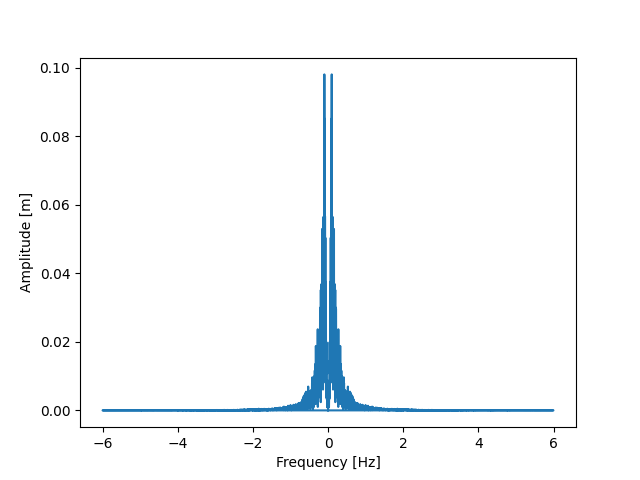

In [23]:
# Apply the franken gaussian filter to the one sided 
width = 0.0005
center = 0.1
gaussian_filter = (1/(np.sqrt(width * 2 * np.pi))) * np.exp(-0.5 * (freq_onesided - center)**2 / width)
gaussian_filter_norm = gaussian_filter / np.max(gaussian_filter)
franken_gaussian_full = gaussian_filter_norm.copy()
franken_gaussian_full[freq_onesided > center] = 1

# Apply the franken gaussian filter to the one sided position spectrum
z_fft_filtered = z_fft_onesided * franken_gaussian_full

# Construct the two sided fft of position from the integrated onesided 
z_fft_twosided = np.empty(num_points, dtype=complex)
z_fft_twosided[0] = 0
z_fft_twosided[1:num_points//2] = z_fft_filtered / 2 # Rescaled by two since it was multiplied by two as a one sidede spectrum
z_fft_twosided[num_points//2+1:] = np.flip(z_fft_filtered) / 2

# Plot the Position spectrum to make sure that it makes sense
fig_pos_fft, ax = plt.subplots()
ax.plot(freq, np.abs(z_fft_twosided))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [m]')


Great! Now we have a two sided spectrum of the filtered position, now lets take the inverse fft and see what the time series looks like!

/Users/ejrainville/Documents/DUNEXMainExp/.dunex-venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Sea Surface Elevation, $\\eta$ [m]')

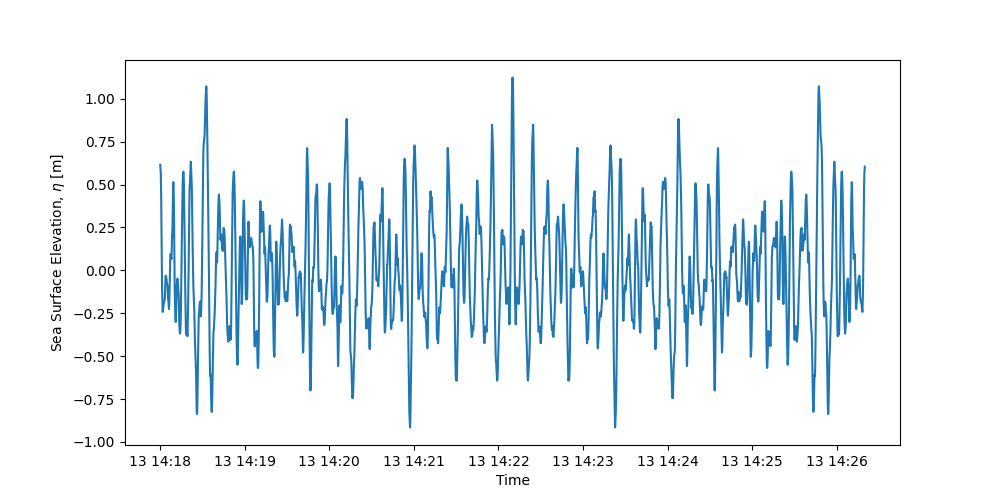

In [24]:
# Compute the Inverse FFT of the filtered and integrated position
eta = np.fft.ifft(z_fft_twosided * num_points) # Note that it must be rescaled by the number of points since we divide by the number of points upon transforming into the fourier domain

# Plot the time series of the sea surface elevation
fig_eta, ax = plt.subplots(figsize=(10,5))
ax.plot(time_datetime, eta)
ax.set_xlabel('Time')
ax.set_ylabel('Sea Surface Elevation, $\eta$ [m]')